In [130]:
# To prepare for using stuff later

# html linking
from IPython.display import HTML

#plotting
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#data manipulation
import pandas as pd
pd.set_option('display.max_colwidth',100)
import operator as op
from spartan.utils.annotations.intervals import Interval



#getting fasta records
from spartan.utils.fastas import ParseFastA


# Counting the SNPs in proximity windows

The following script was used on an interactive `qsub` session to generate the counts:

Name: `/home2/wd238/scripts/Tsetse_RAD_53_v_GfusI1.0.windows.sh`

```shell
#!/bin/zsh

#module purge
#module load bedtools/2.17.0-137-g83ce948

OUT_DIR=$HOME/data/projects/ddrad58

VCF=$HOME/data/genomes/glossina_fuscipes/annotations/SNPs/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.vcf
GFF3=$HOME/data/genomes/glossina_fuscipes/annotations/Glossina-fuscipes-IAEA_BASEFEATURES_GfusI1.0.gtf
BASENAME=tsetseFINAL_14Oct2014_f2_53_v_GfusI1.0.window


LENGTH=500
grep -P "\sgene\s" $GFF3 | bedtools window -a stdin -b $VCF -c -w $LENGTH > ${OUT_DIR}/${BASENAME}.${LENGTH}.tsv

LENGTH=1000
grep -P "\sgene\s" $GFF3 | bedtools window -a stdin -b $VCF -c -w $LENGTH > ${OUT_DIR}/${BASENAME}.${LENGTH}.tsv

LENGTH=5000
grep -P "\sgene\s" $GFF3 | bedtools window -a stdin -b $VCF -c -w $LENGTH > ${OUT_DIR}/${BASENAME}.${LENGTH}.tsv

LENGTH=10000
grep -P "\sgene\s" $GFF3 | bedtools window -a stdin -b $VCF -c -w $LENGTH > ${OUT_DIR}/${BASENAME}.${LENGTH}.tsv

```

# Exploration of SNP counts.

In [82]:
# load the data files
base_dir = "/home/gus/remote_mounts/louise/data"

w500 = base_dir + "/projects/ddrad58/tsetseFINAL_14Oct2014_f2_53_v_GfusI1.0.window.500.tsv"
w1000 = base_dir + "/projects/ddrad58/tsetseFINAL_14Oct2014_f2_53_v_GfusI1.0.window.1000.tsv"
w5000 = base_dir + "/projects/ddrad58/tsetseFINAL_14Oct2014_f2_53_v_GfusI1.0.window.5000.tsv"
w10000 = base_dir + "/projects/ddrad58/tsetseFINAL_14Oct2014_f2_53_v_GfusI1.0.window.10000.tsv"

fasta_path = base_dir + "/genomes/glossina_fuscipes/annotations/seqs/Glossina-fuscipes-IAEA_PEPTIDES_GfusI1.0.fa"

header_values = ["seqname",
                 "source",
                 "feature",
                 "start",
                 "end",
                 "score",
                 "strand",
                 "frame",
                 "attributes",
                 "snp_count"]

w500 = pd.read_table(w500, sep='\t', names=header_values)
w1000 = pd.read_table(w1000,sep='\t', names=header_values)
w5000 = pd.read_table(w5000,sep='\t', names=header_values)
w10000 = pd.read_table(w10000,sep='\t', names=header_values)

# Prepare to build links to the genome browser
base_link = "https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=%(scaffold)s:%(start)s-%(end)s"

### Add SNP density to the stats

- Calculate size of window
- calculate SNP/KB for the window
- add first two to the dataframes

In [58]:
# set up some helper operators to make getting columns easier and clearer
seqname = op.attrgetter('seqname')
source = op.attrgetter('source')
feature = op.attrgetter('feature')
start = op.attrgetter('start')
end = op.attrgetter('end')
score = op.attrgetter('score')
strand = op.attrgetter('strand')
frame = op.attrgetter('frame')
attributes = op.attrgetter('attributes')
snp_count = op.attrgetter('snp_count')
snps_per_kb = op.attrgetter('snps_per_kb')
gene_len = op.attrgetter('gene_len')

In [59]:
def get_snps_per_kb(data_frame,window_size):
    return snp_count(data_frame)/((end(data_frame) - start(data_frame) + window_size) / 1000)

In [60]:
def get_gene_names(data_frame):
    f = lambda x: x.split('"')[1]
    gene_names = attributes(data_frame).map(f)
    return gene_names

In [117]:
def get_links_to_genome_browser(series):
    link = base_link % {"scaffold":series.ix['seqname'],"start":series.ix['start'],"end":series.ix['end']}
    return link
    

In [128]:
def make_report_table(data_frame, window_size):
    snps_per_kb = get_snps_per_kb(data_frame, window_size)
    #gene_names = get_gene_names(data_frame)
    gene_len = end(data_frame) - start(data_frame)
    genome_links = data_frame.apply(get_links_to_genome_browser, axis=1)
    
    report_table = data_frame[["seqname","start","end","attributes","snp_count"]]
    report_table['gene_len'] = gene_len
    report_table['snps_per_kb'] = snps_per_kb
    report_table['genome_browser'] = genome_links
    
    return report_table
    

In [132]:
report_w500 = make_report_table(w500, 500)
report_w1000 = make_report_table(w1000, 1000)
report_w5000 = make_report_table(w5000, 5000)
report_w10000 = make_report_table(w10000, 10000)

In [133]:
report_w500.sort(columns='snps_per_kb', ascending=False)

,seqname,start,end,attributes,snp_count,gene_len,snps_per_kb,genome_browser
20479,Scaffold300,46846,46918,"gene_id ""GFUI053688"";",9,72,15.734266,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold300:46846-46918
17631,Scaffold1324,760,832,"gene_id ""GFUI053641"";",8,72,13.986014,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold1324:760-832
1084,Scaffold676,99621,99693,"gene_id ""GFUI054062"";",8,72,13.986014,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold676:99621-99693
10787,Scaffold868,59371,59442,"gene_id ""GFUI054081"";",7,71,12.259194,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold868:59371-59442
656,Scaffold1385,595,717,"gene_id ""GFUI053818"";",7,122,11.254019,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold1385:595-717
8935,Scaffold538,143642,143714,"gene_id ""GFUI053618"";",6,72,10.489510,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold538:143642-143714
22011,Scaffold630,39025,39106,"gene_id ""GFUI053662"";",6,81,10.327022,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold630:39025-39106
2141,Scaffold169,26677,27184,"gene_id ""GFUI011106"";",9,507,8.937438,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold169:26677-27184
5291,Scaffold247,200858,200930,"gene_id ""GFUI053842"";",5,72,8.741259,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold247:200858-200930
19486,Scaffold281,179513,179816,"gene_id ""GFUI022030"";",7,303,8.717310,https://www.vectorbase.org/Glossina_fuscipes/Location/View?r=Scaffold281:179513-179816


In [144]:
report_w500['snps_per_kb'].std()

0.69085045685113289

In [145]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [151]:
report_w500['gene_len'].describe?


Object `describe` not found.


In [152]:
report_w500['gene_len'].describe?

Object `describe` not found.


In [164]:
gl = report_w500['gene_len']
gl.quantile(0.3333)

2598.0

In [165]:
def partition_by_length(data_frame):
    gene_len = data_frame['gene_len']
    quant_0_3333 = gene_len.quantile(0.3333)
    quant_0_6667 = gene_len.quantile(0.6667)
    s = data_frame[data_frame['gene_len'] <= quant_0_3333]
    m = data_frame[(data_frame['gene_len'] > quant_0_3333) and (data_frame['gene_len'] <= quant_0_6667)]
    l = data_frame[data_frame['gene_len'] > quant_0_6667]
    
    return {'short':s, 
            'medium':m,
            'long':l
           }

In [166]:
partitioned_by_length = partition_by_length(w500)

KeyError: 'gene_len'

In [160]:
def plot_stdzd_scatter(data_frame):
    gene_len = data_frame['gene_len']
    stdzd_snp_rate = standardize(data_frame['snps_per_kb'])
    
    plt.scatter(x=gene_len, 
                y=stdzd_snp_rate, 
                s=20, c=u'b', marker=u'o', 
                cmap=None, norm=None, 
                vmin=None, vmax=None, 
                alpha=0.1, linewidths=None,
                verts=None, hold=None,

               )

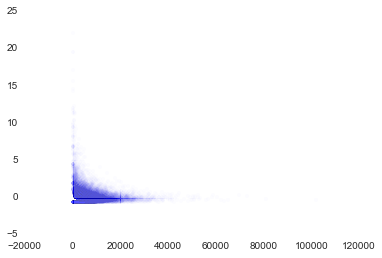

In [147]:
short = report_w500[report_w500['gene_len'] < 125]

plt.scatter(x=report_w500['gene_len'], 
            y=standardize(report_w500['snps_per_kb']), 
            s=20, c=u'b', marker=u'o', 
            cmap=None, norm=None, 
            vmin=None, vmax=None, 
            alpha=0.01, linewidths=None,
            verts=None, hold=None,
            
           )

In [140]:
plt.scatter?

### Peek at what these data look like

In [13]:
w500.head()

,seqname,source,feature,start,end,score,strand,frame,attributes,snp_count
0,Scaffold560,VectorBase,gene,4001,21246,.,+,.,"gene_id ""GFUI039315"";",8
1,Scaffold560,VectorBase,gene,36941,42913,.,-,.,"gene_id ""GFUI039316"";",5
2,Scaffold560,VectorBase,gene,90767,93881,.,+,.,"gene_id ""GFUI039318"";",3
3,Scaffold560,VectorBase,gene,107797,114222,.,+,.,"gene_id ""GFUI039319"";",2
4,Scaffold560,VectorBase,gene,121420,130005,.,+,.,"gene_id ""GFUI039320"";",8


## Distributions:

In [14]:
# function to plot histograms of our counts
def snp_hist(data, bins=20, title=None):
    plt.hist(data, bins=bins, histtype=u'stepfilled', log=1)
    plt.xlabel("SNPs")
    plt.ylabel("Number of Tx")
    if title:
        plt.title(title)

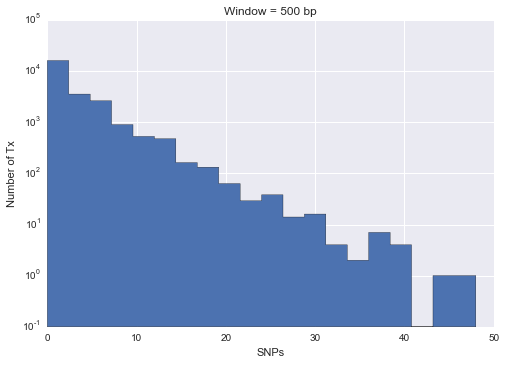

In [15]:
snp_hist(w500["snp_count"],title="Window = 500 bp")

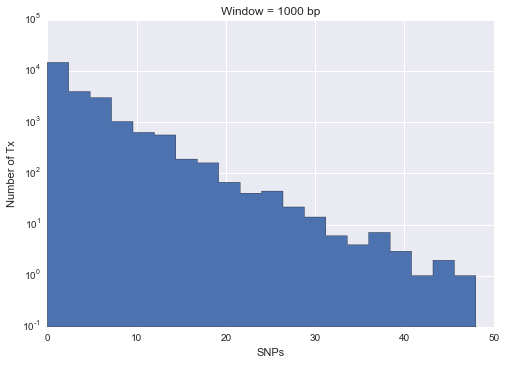

In [16]:
snp_hist(w1000["snp_count"],title="Window = 1000 bp")

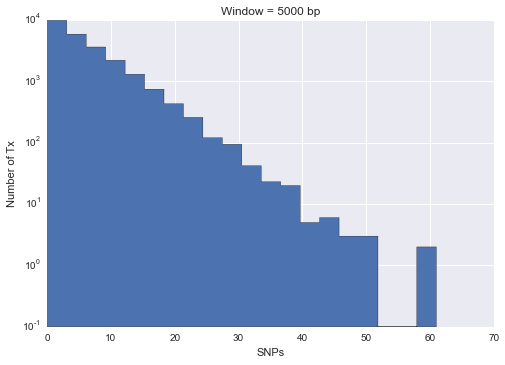

In [17]:
snp_hist(w5000["snp_count"],title="Window = 5000 bp")

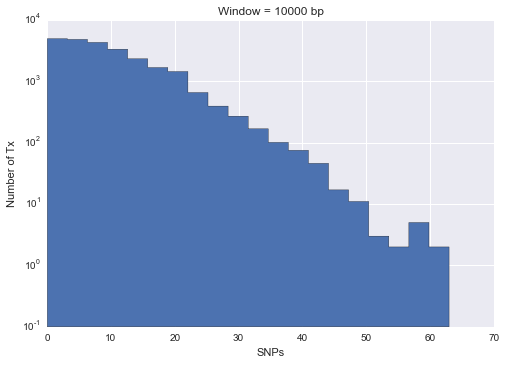

In [18]:
snp_hist(w10000["snp_count"],title="Window = 10000 bp")

## Lets look at some genes:

Looks like a few genes have 30 or more SNPs within even 500 bp. Lets find out which ones.

In [19]:
w500[w500.snp_count >= 30].sort(columns='snp_count', ascending=False)

,seqname,source,feature,start,end,score,strand,frame,attributes,snp_count
9695,Scaffold146,VectorBase,gene,72653,142461,.,-,.,"gene_id ""GFUI008613"";",48
1019,Scaffold264,VectorBase,gene,229325,302075,.,+,.,"gene_id ""GFUI020545"";",45
21658,Scaffold955,VectorBase,gene,52645,66922,.,+,.,"gene_id ""GFUI052300"";",40
18882,Scaffold43,VectorBase,gene,1025058,1042653,.,-,.,"gene_id ""GFUI033156"";",40
18179,Scaffold437,VectorBase,gene,192815,212915,.,-,.,"gene_id ""GFUI032897"";",39
2148,Scaffold169,VectorBase,gene,92009,103492,.,-,.,"gene_id ""GFUI011116"";",39
7210,Scaffold403,VectorBase,gene,7830,27161,.,+,.,"gene_id ""GFUI030992"";",38
7868,Scaffold29,VectorBase,gene,98065,156623,.,-,.,"gene_id ""GFUI023260"";",38
23335,Scaffold323,VectorBase,gene,24405,68980,.,+,.,"gene_id ""GFUI025449"";",38
4533,Scaffold333,VectorBase,gene,263795,294979,.,-,.,"gene_id ""GFUI026118"";",38


In [21]:
w1000[w1000.snp_count >= 30].sort(columns='snp_count', ascending=False)

,seqname,source,feature,start,end,score,strand,frame,attributes,snp_count
9695,Scaffold146,VectorBase,gene,72653,142461,.,-,.,"gene_id ""GFUI008613"";",48
1019,Scaffold264,VectorBase,gene,229325,302075,.,+,.,"gene_id ""GFUI020545"";",45
18179,Scaffold437,VectorBase,gene,192815,212915,.,-,.,"gene_id ""GFUI032897"";",44
18882,Scaffold43,VectorBase,gene,1025058,1042653,.,-,.,"gene_id ""GFUI033156"";",43
21658,Scaffold955,VectorBase,gene,52645,66922,.,+,.,"gene_id ""GFUI052300"";",40
23335,Scaffold323,VectorBase,gene,24405,68980,.,+,.,"gene_id ""GFUI025449"";",39
2148,Scaffold169,VectorBase,gene,92009,103492,.,-,.,"gene_id ""GFUI011116"";",39
5857,Scaffold414,VectorBase,gene,71134,89795,.,+,.,"gene_id ""GFUI031650"";",38
7868,Scaffold29,VectorBase,gene,98065,156623,.,-,.,"gene_id ""GFUI023260"";",38
7210,Scaffold403,VectorBase,gene,7830,27161,.,+,.,"gene_id ""GFUI030992"";",38


In [22]:
w5000[w5000.snp_count >= 30].sort(columns='snp_count', ascending=False)

,seqname,source,feature,start,end,score,strand,frame,attributes,snp_count
9695,Scaffold146,VectorBase,gene,72653,142461,.,-,.,"gene_id ""GFUI008613"";",61
2148,Scaffold169,VectorBase,gene,92009,103492,.,-,.,"gene_id ""GFUI011116"";",58
23335,Scaffold323,VectorBase,gene,24405,68980,.,+,.,"gene_id ""GFUI025449"";",50
12480,Scaffold52,VectorBase,gene,572913,598221,.,+,.,"gene_id ""GFUI037983"";",49
1019,Scaffold264,VectorBase,gene,229325,302075,.,+,.,"gene_id ""GFUI020545"";",49
18882,Scaffold43,VectorBase,gene,1025058,1042653,.,-,.,"gene_id ""GFUI033156"";",47
18179,Scaffold437,VectorBase,gene,192815,212915,.,-,.,"gene_id ""GFUI032897"";",46
5049,Scaffold178,VectorBase,gene,268819,282874,.,-,.,"gene_id ""GFUI012105"";",46
13986,Scaffold244,VectorBase,gene,122079,141066,.,-,.,"gene_id ""GFUI018976"";",45
21658,Scaffold955,VectorBase,gene,52645,66922,.,+,.,"gene_id ""GFUI052300"";",45


In [23]:
w10000[w10000.snp_count >= 30].sort(columns='snp_count', ascending=False)

,seqname,source,feature,start,end,score,strand,frame,attributes,snp_count
9695,Scaffold146,VectorBase,gene,72653,142461,.,-,.,"gene_id ""GFUI008613"";",63
18179,Scaffold437,VectorBase,gene,192815,212915,.,-,.,"gene_id ""GFUI032897"";",62
12480,Scaffold52,VectorBase,gene,572913,598221,.,+,.,"gene_id ""GFUI037983"";",58
11110,Scaffold64,VectorBase,gene,452958,479704,.,-,.,"gene_id ""GFUI042980"";",58
2148,Scaffold169,VectorBase,gene,92009,103492,.,-,.,"gene_id ""GFUI011116"";",58
18882,Scaffold43,VectorBase,gene,1025058,1042653,.,-,.,"gene_id ""GFUI033156"";",58
1019,Scaffold264,VectorBase,gene,229325,302075,.,+,.,"gene_id ""GFUI020545"";",57
7210,Scaffold403,VectorBase,gene,7830,27161,.,+,.,"gene_id ""GFUI030992"";",55
18148,Scaffold446,VectorBase,gene,25317,65256,.,+,.,"gene_id ""GFUI033430"";",54
23335,Scaffold323,VectorBase,gene,24405,68980,.,+,.,"gene_id ""GFUI025449"";",53


- Lets look at the most SNPy of each 


In [20]:
# Load the PEPTIDE seqs
fastas = ParseFastA(fasta_path).to_dict()

In [26]:
fastas["GFUI008613-PA"]

'MVVESSQFASKKYMRRISKDICTVRRISVINSDIKNSPSLSRKHSTNGDLPSRKYARKRSSISSTLTRVLILNVRDLLRTPDPSERQHQPRSWIETNFQKRECIKFIPCPKDDTKCCCGQSRQTHQTIPGVDCGSPGDVWMPHKHTRAQPTDAYGTIEFQGGAHPTKAQYVRLSFETRPELLVQLFTKEWNLELPKLLITVQGGKANFELQPKLKKEIRKGLLKAAKTTGAWIFTGGTNTGVTKQVGDALLLEGQQRTGRVVSIGIAPWGIVERNHELLGHNREVPCHSISSPRSKLAVLNNRHAYFLLVDNGTQAKYGAELILRRKLEKFISNLKLHPFTHSSTPVVCLVIEGGTNTIRAVLEYVTDTPPVPVVVCDGSGRAADLIAFVHKYTSDSDEQAILESTREYLIATIQKTFEVVPEQAEKLYQELLQCTRNKNLITVFRIQEKPEGEAQELDQTILTALFKSQHLSPPEQLSLALTWNRVDIARSEIFVYGQEWPLGALDEAMMQALEHDRIDFVKLLLENGVSMKKFLTIPRLEELYNTKHGPANTLGYILRDVRPHIPKGYIYTLHDIGLVINKLMGGAYRSYYTRRKFRPIYAKVMNSYANAHRKSSTYQRYAGANSLSLVTGLMPFTSEMALFEFPFNELLIWAVLTKRQQMALLMWTHGEEALAKSLVACKLYKAMAHEAAEDDLDTEIYEELRSYAKEFESKGLKLLDFSYRTDGEKAQRLLTCELHSWSNQSCLSLAVAANHRALLAHPCSQVILADLWMGGLRTRKNTNFKVILGLVLPYYIKHLDFKSKEELQQMPQTEEEHLENQNLDNDDSDRSHPDAENPLTKAKRTISLKCRMGSNANNNPDKCKLLQVEKSPPSPSNSYTNSTNALLPDTYSLRDTKVHENGKVSLTDSDPSQFRDFFHMTEYEVKQHQPLRLKKKFYEFYTAPITKFWADSIAYMFFLVMFTYTVLVKMEATPRWQEIYSIAYIATLGFEKIREIIS

In [15]:
fastas["m.135635"]

'CAGCAACAACAGCAGCAACAACCACCACATCCAGCACATCAGCAACCACCGCATCCCCAACATCAGCAGCATGGTCCACCCCATCCTTCGCAAATGTCATCGCATCAATTTAATTCGAATTTGCTAAATCACGCTATGAACAATCCGGCCGCTGCGGCAGCTGCAGCTGCAGCTATTGCGGCCGGTATGCCGCACATGCAATTGCCACCAGCTATGCAGAGTGGCAATATTTATGATCATCCCGGCGTTCATCCGGGTGTAGGAATGAATGGAGTAGGTGTTCCAAAACCGCCCCAACCTGGACAACCAGGTCCCGGCGAATTGGTATATTTAGGCGGACAACCCCATGCAGCGGCTGCAGCCGCTTTGGGCATGATGCCACAAAATCAATTTCTAAGTAATCAAGCAGCTGCCGCAGCTGCGGCTGCTAATCGCAATGCTGCAGCGATTACTACATCCACTGCCAAAAAGCTATGGGAGAAATCCGATGGCAAAGGTGCCTCTACCGGTGGCCCCTTAAATCCCTTACATATTGGGGATCCACACGTTTGGAAAGATTCACCATGGTCGACGCAAGGAGAAACTATATTACCCAGGCCACGTACTTTTCCCCAGGCACCAGATACAACAGTGAGCGCAAATGCCGGAATATTAAGTCCTCGCGATTCGACAAGTGGTCTGGGAGTTAAAATGGTTGAATACGTTTTAGGAGGATCGCCGACAAATAAAGACAGTCCTTTGTCAGGCTTGGAACCACGACTGAGAAGCTTAAAATTCGATGATAGTGATAAGTCACACGATGATAAAGAGAAGGGGAATTCACCATTTGATTCAAATGGCTTAAAGAAGGATGATCAAGTCACCGGAACAAATGGTGTTGTCAACGGTATCGATGATGATAAAGGATTCAACCGTACACCGGGTTCGCGTCAACCTTCACCAGCTGAAGAATCTCTACCACGACCACCCACTTTACTTGATCCTACGCAACATGGTGTC

### `Blastp` on `nr` database filtered for `arthropoda`:

In [17]:
from IPython.display import HTML
HTML('<iframe src=http://www.ncbi.nlm.nih.gov/BLAST/Blast.cgi?CMD=Get&RID=0TDSJU69014 width=900 height=650></iframe>')

### Results:

- Lots of pumilio-like hits.
- More to come tomorrow.